#### TENTATIVE UTLISATION DU TMJA dans le score

Notebook amorcé par : Jesshuan

Test ultime sur la France entière

Objectifs :

- à partir des fichiers geopandas "dataset_communes", "dataset_charge_points" et "TMJA2018" précedemment récupérés et complétés par l'équipe, évaluer la faisabilité et la pertinence des ompositions de sous-scores décrit dans les "Pistes de scores" (https://www.notion.so/dataforgood/New-Pistes-pour-le-score-1410a2aff0ee4b11b073b1850c87a95e) pour les sous-scores 1 et 2, qui font intervenir le TJMA "touristique", à savoir le TJMA de chaque route amputée de sa composante "locale".

- dans tous les cas, en profiter pour manier les alogorithmes de calcul type "plus proche route d'une commune", qui sera de toutes façons très certainement utilisé

- factoriser le code depuis le premier test Bouches-du-Rhône, enlever la partie analyse technique...

- amélioration de l'algorithme de recherche de plus proche route (temps divisé par 10)

Imports :

In [1]:
import geopandas as gpd
import geopy.distance
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import copy

In [2]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [40]:
# OPTIONNAL : Import et test avec TMJA 2019, qui est un fichier plus incomplet (et routes encore plus discontinues...) que 2018

'''# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')
file_name = 'TMJA2019'
ext = '.shp'
url = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'
temp_path = 'temp_unzip'

try: 
    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))
except:
    # From url
    zip_file = requests.get(url).content
    os.makedirs(temp_path, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:
        archive.extractall(temp_path)
    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))
    shutil.rmtree(temp_path)

    # From local file
    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))

    # avoiding multi dowloads for GES emmision lowering
    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))'''

"# tmja = gpd.read_file('C:/Users/demo/Desktop/Lattitude/datas/tmja2018-shp/TMJA2018.shp')\nfile_name = 'TMJA2019'\next = '.shp'\nurl = 'https://static.data.gouv.fr/resources/trafic-moyen-journalier-annuel-sur-le-reseau-routier-national/20211222-170254/tmja2019-shp.zip'\ntemp_path = 'temp_unzip'\n\ntry: \n    tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))\nexcept:\n    # From url\n    zip_file = requests.get(url).content\n    os.makedirs(temp_path, exist_ok=True)\n    with zipfile.ZipFile(io.BytesIO(zip_file)) as archive:\n        archive.extractall(temp_path)\n    tmja = gpd.read_file(os.path.join(temp_path,file_name + ext))\n    shutil.rmtree(temp_path)\n\n    # From local file\n    # tmja = gpd.read_file(os.path.join(data_path,file_name + ext))\n\n    # avoiding multi dowloads for GES emmision lowering\n    tmja.to_feather(os.path.join(data_path,file_name + '.feather'))"

In [3]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

Conversion dans le système ws84 (coordonnées GPS standard) :

In [4]:
tmja_wrs84 = tmja.to_crs(4326)

<Axes: >

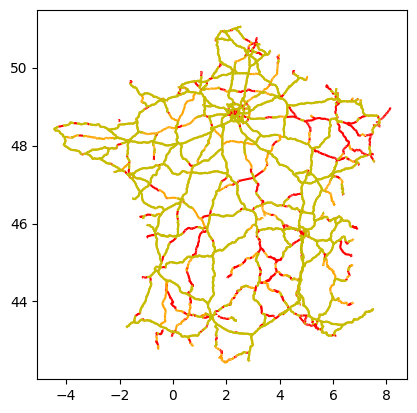

In [5]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84.loc[tmja_wrs84['tmja']==0,:].plot(ax=ax, color='r')
tmja_wrs84.loc[tmja_wrs84['tmja']>0,:].plot(ax=ax, color='orange')
tmja_wrs84.loc[tmja_wrs84['tmja']>10000,:].plot(ax=ax, color='y')



Piste : Extrapolation du traffic possible par déduction via les plus proches voisines non nulles (de manière itérative)

La fonction ci-dessous extrapole le tmja des routes aux tmja nuls, grâce aux routes strictement adjacentes (point de départ = point d'arrivée de la route adjacente, point d'arrivée = point de départ de la route adjacente, point de départ = point de départ...) Une moyenne est faite parmi toutes les routes trouvées adjacentes (moyenne des routes à gauche et à droite, ou une seule route dans le cas d'une impasse, etc...)
Le processus est réitéré n fois (n défini à 30 ici), pour permettre le plus de complétion possibles (progression de proche en proche, dans le cas où plusieurs routes avec un tmja nulle se succède)


In [6]:
def split_and_fill_Local_null_values_by_key(df, column_key, missing_value=0,nb_rep=10, buffer_size=0.01):

    geometry_conservation = df.geometry

    df_clean = copy.copy(df)

    try:
        df_clean.reset_index(names="road_index", inplace=True)
    except Exception as e:
        print(e)
        pass

    df_buf = df_clean.buffer(buffer_size)

    df_clean.geometry = df_buf

    total_values = 0

    for k in range(nb_rep):

        new_column = []
        values = 0

        column_list = df_clean[column_key].to_list()
        index_list = df_clean['road_index'].to_list()

        df_join_road = df_clean.sjoin(df_clean, how='inner')
        df_join_road_clean = df_join_road.loc[df_join_road['road_index_left']!=df_join_road['road_index_right'],:]
        dict_new = df_join_road_clean[['road_index_left',f'{column_key}_right']].groupby('road_index_left').mean().to_dict()[f'{column_key}_right']

        for i, index in enumerate(index_list):
            old_tmja = column_list[i]
            if old_tmja == missing_value or str(old_tmja)==missing_value:
                try:
                    new_column.append(dict_new[index])
                    values+=1
                except:
                    new_column.append(old_tmja)
            else:
                new_column.append(old_tmja)
        
        df_clean[column_key] = new_column
    
        total_values += values

        print(f'... {k+1} rounds done. {values} are been modified... Total values modified : {total_values}')
    
    df_clean.geometry = geometry_conservation

    return df_clean

In [7]:
tmja_wrs84_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84, column_key='tmja', nb_rep=15)

/tmp/ipykernel_7598/3422367474.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_buf = df_clean.buffer(buffer_size)


... 1 rounds done. 1543 are been modified... Total values modified : 1543
... 2 rounds done. 571 are been modified... Total values modified : 2114
... 3 rounds done. 312 are been modified... Total values modified : 2426
... 4 rounds done. 172 are been modified... Total values modified : 2598
... 5 rounds done. 87 are been modified... Total values modified : 2685
... 6 rounds done. 49 are been modified... Total values modified : 2734
... 7 rounds done. 29 are been modified... Total values modified : 2763
... 8 rounds done. 19 are been modified... Total values modified : 2782
... 9 rounds done. 17 are been modified... Total values modified : 2799
... 10 rounds done. 12 are been modified... Total values modified : 2811
... 11 rounds done. 7 are been modified... Total values modified : 2818
... 12 rounds done. 3 are been modified... Total values modified : 2821
... 13 rounds done. 1 are been modified... Total values modified : 2822
... 14 rounds done. 0 are been modified... Total values mo

Résultats de la complétion :

<Axes: >

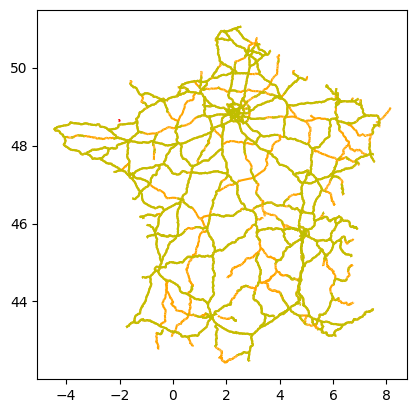

In [8]:
fig, ax = plt.subplots(1, 1)

tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja']==0,:].plot(ax=ax, color='r')
tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja']>0,:].plot(ax=ax, color='orange')
tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja']>10000,:].plot(ax=ax, color='y')

-----

On récupère aussi les centres de routes :

In [9]:
tmja_wrs84_clean['Road_center'] = tmja_wrs84_clean.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

---------

Données des communes :

Les lignes des données de communes sont redondantes, car les données d'enregistrement des véhicules sont trimestriels. On récupère donc ici seulement les données les plus actuelles :

In [8]:
communes_fin_2022 = datas.loc[datas['date_arrete']=='2022-12-31']

On ne va garder que les communes en métropole :

In [9]:
extra_metropole = [code_insee for code_insee in communes_fin_2022['insee'].to_list() if code_insee[0:2]=='2A' or code_insee[0:2]=='2B' or code_insee[0:2]=='97' or code_insee[0:2]=='98']

In [10]:
communes_metropole = communes_fin_2022.loc[~communes_fin_2022['insee'].isin(extra_metropole),:]

On ajoute une colonne au dataframe pour accéder directement au centre de la commune :

In [11]:
communes_metropole['coords_centre'] = communes_metropole.to_crs('+proj=cea').geometry.centroid.to_crs(communes_metropole.crs)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


-----------

TENTATIVE DE DISSOCIATION DU TMJA EN TJMA GLOBAL ET TJMA TOURSTIQUE :

Définition du périmètre de sélection initial (pour limiter les calculs) : un cercle de grand rayon (70 km à vol d'oiseau) en s'assurant que toute commune possède bien au moins une route dans ce rayon, dans la France entière.
Pour chaque commune, on va d'abord dresser la liste de toutes les routes éligibles (selon distance à vol d'oiseau) dans ce rayon, avant de passer à un calcul plus précis...

In [12]:
DIST_VOL_OISEAU = 70000 # meters

Au lieu d'utiliser une ancienne version du code, on utilise ici la fonction "buffer" de geopandas, pour dresser la liste des routes proches de chaque communes, dans un certain rayon. De fait, ce "rayon" ne dessine plus un cercle avec cette fonction. Mais l'important est que chaque point géographique de la carte de France possède bien au moins une route en largeur dans ce ovale...

/tmp/ipykernel_261535/1037946298.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  communes_metropole.loc[communes_metropole['insee']=='58170','coords_centre'].buffer(1).plot(ax=ax)


<Axes: >

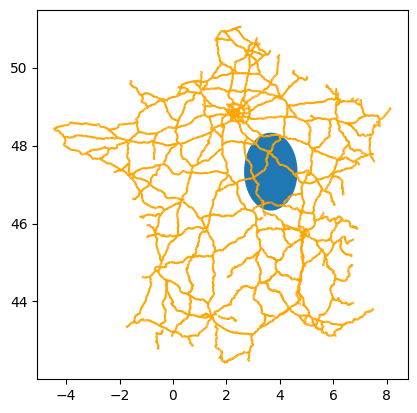

In [13]:
fig, ax = plt.subplots(1, 1)
communes_metropole.loc[communes_metropole['insee']=='58170','coords_centre'].buffer(1).plot(ax=ax)
tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja']>0,:].plot(ax=ax, color='orange')


Un buffer de valeur 1 semble donc convenir

Récupération des index des routes grâce à la fonction spatial join de GeoPandas :

In [14]:
comm_met_reduce = communes_metropole[['insee', 'coords_centre']]
tmja_wr84_reduce = tmja_wrs84_clean[['road_index','Road_center']]

In [15]:
big_join_distance = comm_met_reduce.set_geometry("coords_centre").buffer(1).to_frame().sjoin(tmja_wr84_reduce.set_geometry('Road_center'), how='right')

/tmp/ipykernel_261535/2874144568.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  big_join_distance = comm_met_reduce.set_geometry("coords_centre").buffer(1).to_frame().sjoin(tmja_wr84_reduce.set_geometry('Road_center'), how='right')


Grâce à un "group by" on peut observer le nombre de communes qui n'ont aucune route associée dans le résultat :

In [16]:
total_count_roads = big_join_distance.groupby('index_left').count()

In [17]:
total_count_roads.loc[total_count_roads['road_index']==0,:]

Empty DataFrame
Columns: [road_index, Road_center]
Index: []

Il n'y en a aucune, ce qui signifie que notre buffer était assez gros. Il a fallu en plus prendre plus large, à cause de la déformation du buffer en hauteur et largeur.

On récupère, sous forme de Series de listes, puis de liste de liste, la liste des routes concurrentes pour chaque commune :

In [18]:
roads_list_global = big_join_distance.groupby('index_left')['road_index'].apply(list).to_list()

Puis on itère sur chaque commune, pour récupérer dans la liste des routes concurrentes, celles qui est la plus proche, en observant les coordonnées de cahque point de la routes, et en calculant la distance du centre de la commune à ce point :

ATTENTION : Temps long de calcul. Le fichier commune final a été exporté et peut être réimporté plus bas.

In [19]:
nearlier_road_dist = []
nearlier_road = []
problematic_road = []

index_com_list = communes_metropole.index.to_list()
list_geometry_road = tmja_wrs84.geometry.to_list()
geo_centers_road = tmja_wrs84_clean['Road_center'].geometry
geo_communes_centers = communes_metropole['coords_centre'].geometry

for k, coord_center in enumerate(geo_communes_centers):

    dist_minimal = DIST_VOL_OISEAU # valeur par défault si aucune distance n'est trouvée

    for road_index in roads_list_global[k]:
        try:
            list_coords_nearly=[tupple_coord for tupple_coord in list_geometry_road[road_index].coords]
            for i, road_list_points in enumerate(list_coords_nearly):
                min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

                if min_for_this_road < dist_minimal:
                    dist_minimal = min_for_this_road
                    best_road = road_index
        except:
            try:
                list_coords_nearly.append([tupple for linestring in tmja_wrs84.geometry[i].geoms for tupple in linestring.coords])
                for i, road_list_points in enumerate(list_coords_nearly):
                    min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

                if min_for_this_road < dist_minimal:
                    dist_minimal = min_for_this_road
                    best_road = road_index
            except:
                min_for_this_road = geopy.distance.geodesic(coord_center.coords, geo_centers_road[road_index].coords).meters

                if min_for_this_road < dist_minimal:
                    dist_minimal = min_for_this_road
                    best_road = road_index

                problematic_road.append(road_index)

    nearlier_road_dist.append(dist_minimal)
    nearlier_road.append(best_road)

    if k%100==0:
        print(f'{k} communes completed...')

communes_metropole['nearlier_road'] = nearlier_road
communes_metropole['nearlier_road_dist']=  nearlier_road_dist

0 communes completed...
100 communes completed...
200 communes completed...
300 communes completed...
400 communes completed...
500 communes completed...
600 communes completed...
700 communes completed...
800 communes completed...
900 communes completed...
1000 communes completed...
1100 communes completed...
1200 communes completed...
1300 communes completed...
1400 communes completed...
1500 communes completed...
1600 communes completed...
1700 communes completed...
1800 communes completed...
1900 communes completed...
2000 communes completed...
2100 communes completed...
2200 communes completed...
2300 communes completed...
2400 communes completed...
2500 communes completed...
2600 communes completed...
2700 communes completed...
2800 communes completed...
2900 communes completed...
3000 communes completed...
3100 communes completed...
3200 communes completed...
3300 communes completed...
3400 communes completed...
3500 communes completed...
3600 communes completed...
3700 communes

Code annulé (légèrement moins rapide), qui utilisait la fonction spatial join _nearliest de geopandas :

In [ ]:
'''
nearlier_road_dist = []
nearlier_road = []
problematic_road = []

center_city_list = communes_metropole['coords_centre'].to_list()
road_geometry_list = tmja_wrs84.geometry.to_list()

for k, index_com in enumerate(index_com_list):

    road_list = roads_list_global[index_com]

    df_unique_com = communes_metropole.loc[communes_metropole.index==index_com,['insee','coords_centre']].set_geometry('coords_centre')
    df_roads = tmja_wrs84_clean.loc[tmja_wrs84_clean['road_index'].isin(road_list), ['road_index', 'geometry']]

    df_dist_join = df_unique_com.sjoin_nearest(df_roads, how="left", distance_col="Distances")

    coord_center_city = center_city_list[k].coords
    best_road = df_dist_join['road_index'].to_list()[0]

    list_coords_nearly=[tupple_coord for tupple_coord in road_geometry_list[best_road].coords]

    min_dist = min([geopy.distance.geodesic(coord_center_city, tupple).meters for tupple in list_coords_nearly])

    nearlier_road.append(best_road)
    nearlier_road_dist.append(min_dist)

    if k%10==0:
        print(f'{k} communes completed...')

'''

    

Tout premier code (encore moins rapide) :

In [ ]:
'''
nearlier_road = []
nearlier_road_dist = []
multiline_road = []
problematic_road = []

for k, coord_center in enumerate(communes_metropole['coords_centre'].geometry): # pour chaque commune (centre de commune)

    list_index_nearly = []
    list_coord_nearly = []
    list_dist = []


    # ETAPE 1 - SELECTION "À LA LOUCHE" DES ROUTES DANS LE BON RAYON LARGE

    for i, road_center in enumerate(tmja_wrs84_clean['Road_center'].geometry): # pour chaque route du fichier

        dist_oiseau = geopy.distance.geodesic(coord_center.coords, road_center.coords).meters #
        if dist_oiseau<=DIST_VOL_OISEAU: # on ne garde la route que si elle est incluse dans le périmètre défini
            list_index_nearly.append(i)
            try:
                # Ajout de toutes les coordonnées de tous les points de la route dans la liste :
                list_coord_nearly.append([tupple_coord for tupple_coord in tmja_wrs84.geometry.to_list()[i].coords])
            except:
                try:
                    # En cas de MultiStrings (routes discontinues)...
                    # À défaut, ajout de toutes les coordonnées de tous les points de la route dans la liste, en cassant différemment le format :
                    list_coord_nearly.append([tupple for linestring in tmja_wrs84.geometry[i].geoms for tupple in linestring.coords])
                    multiline_road.append(tmja_wrs84_clean.iloc[i, 1])
                except:
                    # En cas de nouveau problème...
                    # On enregistre seulement le centre de la route... (dommage)
                    # On enregistre l'index de la route problématique
                    list_coord_nearly.append([road_center.coords])
                    problematic_road.append(tmja_wrs84_clean.iloc[i, 1])

    
    # ETAPE 2 - CALCUL DE DISTANCE À CHAQUE POINT ROUTE

    # ICI, REMPLACER PAR CALCUL API DE DISTANCE TEMPORELLE ROUTIERE :
    # BOUCLE AVEC REQUETES À L'API POUR EVALUATION DU TEMPS ROUTIER DU POINT COMMUNE/CENTRE-VILLAGE
    # À CHAQUE POINT DE ROUTE DE LA LISTE
    #for coord_road in list_coord_nearly:
        # ...
        # best_dist =
        # best_index = 

    # SOLUTION DE REMPLACEMENT (VOL D'OISEAU) :

    print('step 1 finish')

    dist_minimal = DIST_VOL_OISEAU # défnition de la distance par défaut minimale

    for i, road_list_points in enumerate(list_coord_nearly):

        min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

        if min_for_this_road < dist_minimal:
            dist_minimal = min_for_this_road

            best_road = list_index_nearly[i]


    # ETAPE 3 - ENREGISTREMENT DE LA ROUTE LA PLUS PROCHE + DISTANCE À CETTE ROUTE

    nearlier_road_dist.append(dist_minimal)

    nearlier_road.append(best_road)

    print('step 2 finish')

    if k%10==0:
        print(f'{k} communes completed...')

#communes_metropole['nearlier_road'] = nearlier_road
#communes_metropole['nearlier_road_dist']=  nearlier_road_dist

communes_metropole['nearlier_road'] = nearlier_road
communes_metropole['nearlier_road_dist']=  nearlier_road_dist

'''

In [6]:
set(multiline_road)

NameError: name 'multiline_road' is not defined

In [44]:
set(problematic_road)

set()

Sauvegarde du fichier :

In [ ]:
file_name = 'communes_metro_with_nearlier_road.feather'

communes_metropole.to_feather(os.path.join(data_path, file_name))

Import du fichier :

In [10]:
file_name = 'communes_metro_with_nearlier_road.feather'

communes_metropole = gpd.read_feather(os.path.join(data_path, file_name))

On regarde les routes Multilines (discontinues)

On regarde les routes qui ont posé problème

---------

Affichage par commune, par route la plus proche (chaque commune est rattachée ici à sa route la plus proche) :

In [11]:
communes_metropole_spec = copy.copy(communes_metropole)

In [12]:
communes_metropole_spec['nearlier_road'] = communes_metropole_spec['nearlier_road'].apply(lambda integer : str(integer))

In [13]:
communes_metropole_spec['nearlier_road']

14       4796
15       4826
16        429
17       4822
18       4826
         ... 
34950    3628
34951    3629
34952    3629
34953     820
34954    3629
Name: nearlier_road, Length: 34461, dtype: object

<Axes: >

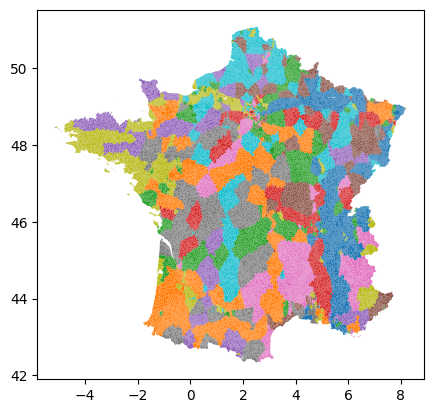

In [14]:
communes_metropole_spec.plot(column='nearlier_road')

Amplification du poids du nombre de véhicule de la commune selon la distance à la route (ici, loi exponentielle par exemple) :

Etude sur échantillon :

In [38]:
communes_metropole['nearlier_road_dist'][0:50]

14     18980.409367
15      6341.065037
16      3774.372674
17       497.027058
18      2650.517409
19      5724.103998
20       694.689356
21       304.665833
22      5053.270334
23      3196.494611
30     16779.345273
31      5178.119587
32       701.101791
33     29732.379296
34     25276.557203
35     22411.973250
36     18495.830172
37     22984.187608
38     22050.592922
39     20312.603902
40     10562.809828
41     11206.552282
42      5760.432123
43      3990.944573
44      3078.431243
45      1934.641774
46      1803.533640
47      6576.908851
48      4970.199757
49     13148.319244
50      6607.482868
51      8570.841105
52       240.219106
53      7514.398982
54      6422.268356
55       770.704744
56      3398.531546
57      3215.728542
58      8450.992428
167    26996.207666
172    26259.429351
173    31718.083694
189     4535.945903
190    25539.522270
191     9243.119617
192     4681.386158
193     4096.117659
194     4720.353756
195     4603.869893
196     1197.673678


In [39]:
gamma = 0.00001

In [40]:
np.exp(-gamma*communes_metropole['nearlier_road_dist'])[0:50]

14     0.827121
15     0.938558
16     0.962960
17     0.995042
18     0.973843
19     0.944366
20     0.993077
21     0.996958
22     0.950723
23     0.968541
30     0.845528
31     0.949537
32     0.993014
33     0.742803
34     0.776650
35     0.799219
36     0.831139
37     0.794659
38     0.802113
39     0.816175
40     0.899759
41     0.893986
42     0.944023
43     0.960876
44     0.969685
45     0.980840
46     0.982126
47     0.936347
48     0.951513
49     0.876794
50     0.936061
51     0.917862
52     0.997601
53     0.927610
54     0.937796
55     0.992323
56     0.966586
57     0.968354
58     0.918963
167    0.763408
172    0.769054
173    0.728199
189    0.955654
190    0.774610
191    0.911712
192    0.954265
193    0.959866
194    0.953893
195    0.955005
196    0.988095
Name: nearlier_road_dist, dtype: float64

In [41]:
communes_metropole['traffic_vp'] = communes_metropole['nb_vp']*np.exp(-gamma*communes_metropole['nearlier_road_dist'])

<Axes: >

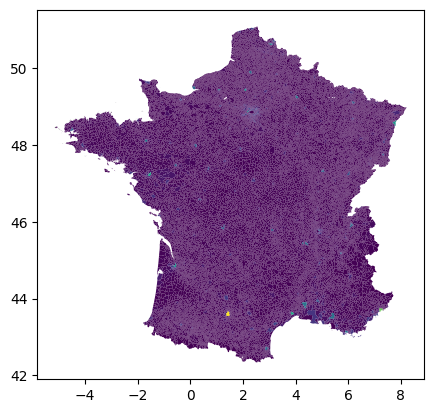

In [42]:
communes_metropole.plot(column='nb_vp')

<Axes: >

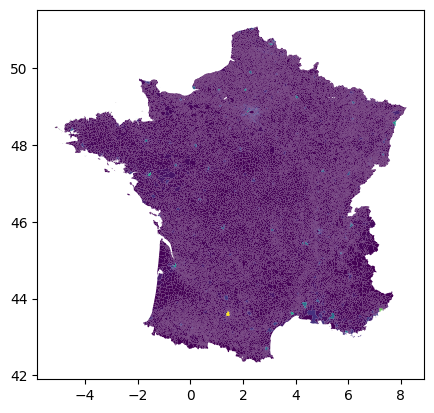

In [43]:
communes_metropole.plot(column='traffic_vp')

Evaluation du trafic local de la route, comme somme (pour chaque commune) des voitures immatriculées de chaque commune (préalablement pondéré par la distance):

In [44]:
traffic_values = communes_metropole.groupby('nearlier_road')['traffic_vp'].sum().to_dict()

On essaie également ici de diviser la valeur par la longueur de la route (une route plus longue a plus de probabilité d'avoir plus communes rattachées)

In [75]:
tmja_wrs84_clean['tmja_local'] = tmja_wrs84_clean['road_index'].map(traffic_values)/tmja_wrs84_clean['longueur']

Distribution totale :

In [52]:
fig = px.histogram(tmja_wrs84_clean, x='tmja_local', nbins=200)
fig.show()

Zoom :

In [51]:
fig = px.histogram(tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja_local']<50,:], x='tmja_local', nbins=200)
fig.show()

Visualisation des routes qui ont des communes rattachées :

<Axes: >

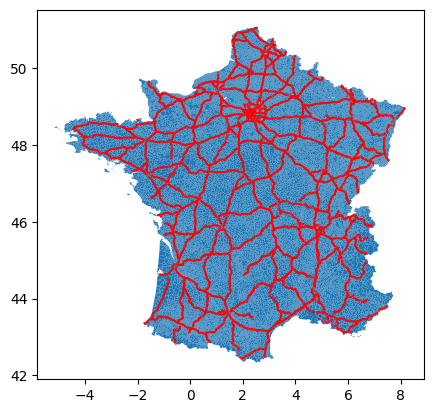

In [76]:
tmja_wrs84_not_null = tmja_wrs84_clean.loc[tmja_wrs84_clean.index.isin(traffic_values.keys()),:]

fig, ax = plt.subplots(1, 1)

communes_metropole.plot(ax=ax)
tmja_wrs84_not_null.plot(ax=ax, color='r')

Le "rabattement" du traffic supposé local sur les routes produit une discontinuité. En effet, certaines routes n'ont aucune commune rattachée à elle... [Problème à éventuellement gérer avec une extrapolation moyenne des routes dépourvues de traffic à partir des plus proches voisines]

----------

Extrapolation du traffic local pour les routes "orphelines" (rattachées )

In [77]:
tmja_wrs84_clean = split_and_fill_Local_null_values_by_key(tmja_wrs84_clean, 'tmja_local', missing_value='nan', nb_rep=5, buffer_size=0.01)

cannot insert road_index, already exists


/tmp/ipykernel_7598/3422367474.py:13: UserWarning:

Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




... 1 rounds done. 1827 are been modified... Total values modified : 1827
... 2 rounds done. 49 are been modified... Total values modified : 1876
... 3 rounds done. 9 are been modified... Total values modified : 1885
... 4 rounds done. 5 are been modified... Total values modified : 1890
... 5 rounds done. 0 are been modified... Total values modified : 1890


<Axes: >

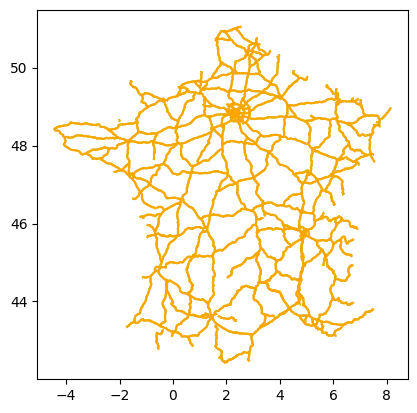

In [48]:
fig, ax = plt.subplots(1, 1)

#tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja_local']==0,:].plot(ax=ax, color='r')
tmja_wrs84_clean.loc[tmja_wrs84_clean['tmja_local']>0,:].plot(ax=ax, color='y')
tmja_wrs84_clean.loc[(tmja_wrs84_clean['tmja_local']>0) & (tmja_wrs84_clean['tmja_local']<3000),:].plot(ax=ax, color='orange')


Problème de discontinuité résolue

-------

Application de la formule du sous-score 2 :

In [78]:
tmja_wrs84_clean[['tmja', 'tmja_local']].describe()

tmja     tmja_local
count    5968.000000    5968.000000
mean    27008.984742     508.265739
std     31186.265507    8718.806983
min         0.000000       0.000142
25%      8028.000000       1.309582
50%     15487.000000       3.996616
75%     33867.750000      15.121561
max    229392.000000  259062.858093

In [79]:
fig = px.histogram(tmja_wrs84_clean, x='tmja', nbins=200)
fig.show()

In [80]:
fig = px.histogram(tmja_wrs84_clean, x='tmja_local', nbins=200)
fig.show()

In [81]:
def remove_outliers(value, mean_value, std_value, nb_std):
    if value < mean_value - nb_std*std_value:
        new_value = mean_value - nb_std*std_value
    elif value > mean_value + nb_std*std_value:
        new_value = mean_value + nb_std*std_value
    else:
        new_value = value
    return new_value

In [59]:
mean = tmja_wrs84_clean['tmja_local'].mean()
std = tmja_wrs84_clean['tmja_local'].std()

tmja_wrs84_clean['tmja_local'] = tmja_wrs84_clean['tmja_local'].apply(lambda value : remove_outliers(value, mean, std, 3))

In [60]:
fig = px.histogram(tmja_wrs84_clean, x='tmja_local', nbins=200)
fig.show()

In [87]:
alpha = 10

In [88]:
tmja_wrs84_clean['tmja_tourist'] = tmja_wrs84_clean['tmja'] - alpha * tmja_wrs84_clean['tmja_local']

In [89]:
min(tmja_wrs84_clean['tmja_tourist'])

-2563369.5809340244

In [90]:
max(tmja_wrs84_clean['tmja_tourist'])

229383.45248326517

In [91]:
fig = px.histogram(tmja_wrs84_clean, x='tmja_tourist', nbins=300)
fig.show()

In [92]:
tmja_wrs84_clean['tmja_tourist'].describe()

count    5.968000e+03
mean     2.192633e+04
std      8.899254e+04
min     -2.563370e+06
25%      7.629538e+03
50%      1.511846e+04
75%      3.340433e+04
max      2.293835e+05
Name: tmja_tourist, dtype: float64

In [93]:
mean = tmja_wrs84_clean['tmja_tourist'].mean()
std = tmja_wrs84_clean['tmja_tourist'].std()

tmja_wrs84_clean['tmja_tourist'] = tmja_wrs84_clean['tmja_tourist'].apply(lambda value : remove_outliers(value, mean, std, 4))

In [94]:
minimum_value = min(tmja_wrs84_clean['tmja_tourist'])

if minimum_value<0:

    tmja_wrs84_clean['tmja_tourist'] = tmja_wrs84_clean['tmja_tourist'] - minimum_value

In [95]:
fig = px.histogram(tmja_wrs84_clean, x='tmja_tourist', nbins=300)
fig.show()

---------

In [53]:
'''
def fast_visualization_specific_tmja(base_geo_df, geo_df, colum_key):
    max_value = max(geo_df[colum_key])
    fig, ax = plt.subplots(1, 1)

    base_geo_df.plot(ax=ax, color='grey')
    geo_df.plot(ax=ax, color='grey')
    geo_df.loc[geo_df[colum_key]>max_value*0.1,:].plot(ax=ax, color='blue')
    geo_df.loc[geo_df[colum_key]>max_value*0.3,:].plot(ax=ax, color='green')
    geo_df.loc[geo_df[colum_key]>max_value*0.5,:].plot(ax=ax, color='y')
    geo_df.loc[geo_df[colum_key]>max_value*0.7,:].plot(ax=ax, color='orange')
    geo_df.loc[geo_df[colum_key]>max_value*0.9,:].plot(ax=ax, color='r')
    fig.show()
'''


In [96]:
lon_list = []
lat_list = []
for i in range(len(tmja_wrs84_clean['Road_center'])):
    lon_list.append(tmja_wrs84_clean['Road_center'].geometry[i].coords[0][0])
    lat_list.append(tmja_wrs84_clean['Road_center'].geometry[i].coords[0][1])



In [97]:
tmja_wrs84_clean['lat_center'] = lat_list
tmja_wrs84_clean['lon_center'] = lon_list

In [98]:
def fast_visualization_specific_tmja(geo_df, colum_key):

    fig = px.scatter_mapbox(geo_df, lat='lat_center', lon='lon_center', color=colum_key, size=colum_key, mapbox_style='open-street-map')

    fig.show()

TMJA TOTAL

In [99]:
fast_visualization_specific_tmja(tmja_wrs84_clean, 'tmja')

In [100]:
fast_visualization_specific_tmja(tmja_wrs84_clean, 'tmja_local')

In [101]:
fast_visualization_specific_tmja(tmja_wrs84_clean, 'tmja_tourist')